In [ ]:
import hcipy as hp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import pickle
import os
import astropy.units as u
from astropy.io import fits
os.getcwd()
plt.rcParams['text.usetex'] = False
perfect = False
perfect_wf = False
if perfect:
    perf_folder = 'perfect'
else:
    perf_folder = 'scalar-vortex'

In [ ]:
with fits.open("metal_pinhole_pupil_plane_arr.fits") as hdul:
    hdu = hdul[0]
    hdr = hdu.header
    indata = hdu.data
print(hdr)
xunpadxr = indata[:,:,0]
xunpadxi = indata[:,:,1]
xunpadx = xunpadxr + 1j*xunpadxi
xunpadyr = indata[:,:,2]
xunpadyi = indata[:,:,3]
xunpady = xunpadyr + 1j*xunpadyi
yunpadxr = indata[:,:,4]
yunpadxi = indata[:,:,5]
yunpadx = yunpadxr + 1j*yunpadxi
yunpadyr = indata[:,:,6]
yunpadyi = indata[:,:,7]
yunpady = yunpadyr + 1j*yunpadyi
arr_width = hdu.header['arrwidth']*u.mm

SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -64 / array data type                                NAXIS   =                    3 / number of array dimensions                     NAXIS1  =                    8                                                  NAXIS2  =                 2048                                                  NAXIS3  =                 2048                                                  EXTEND  =                    T                                                  LAYER_0 = 'real xx '                                                            LAYER_1 = 'imag xx '                                                            LAYER_2 = 'real yx '                                                            LAYER_3 = 'imag yx '                                                            LAYER_4 = 'real xy '                                                            LAYER_5 = 'imag xy '                    

In [51]:
print(type(xunpadx))
print(xunpadx.shape)
print(xunpadx.ravel().shape)

<class 'numpy.ndarray'>
(2048, 2048)
(4194304,)


In [ ]:
focal_length = 0.05
wavelength = 6.328e-7
D = 0.0068 # 0.0045 #
N=xunpadx.shape[0]
pupil_grid = hp.make_pupil_grid(N, arr_width.to(u.m).value)
if perfect_wf:
    xpupil = hp.Field([np.ones(xunpadx.shape).ravel() + 1j*np.zeros(xunpadx.shape).ravel(), np.zeros(xunpadx.shape).ravel() + 1j*np.zeros(xunpadx.shape).ravel()], pupil_grid)
    ypupil = hp.Field([np.zeros(xunpadx.shape).ravel() + 1j*np.zeros(xunpadx.shape).ravel(), np.ones(xunpadx.shape).ravel() + 1j*np.zeros(xunpadx.shape).ravel()], pupil_grid)
else:
    phixx=np.angle(xunpadxr.ravel() + 1j * xunpadxi.ravel())
    phiyy=np.angle(yunpadyr.ravel() + 1j * yunpadyi.ravel())
    phi_avg=(phixx+phiyy)/2
    xpupil = hp.Field([xunpadxr.ravel() + 1j * xunpadxi.ravel(), xunpadyr.ravel() + 1j * xunpadyi.ravel()]*np.exp(-1j*phi_avg), pupil_grid)
    ypupil = hp.Field([yunpadxr.ravel() + 1j * yunpadxi.ravel(), yunpadyr.ravel() + 1j * yunpadyi.ravel()]*np.exp(-1j*phi_avg), pupil_grid)

xwf = hp.Wavefront(xpupil, 6.328e-7)
ywf = hp.Wavefront(ypupil, 6.328e-7)
print(pupil_grid.shape)
print(xpupil.shape)
print(xwf.electric_field.shape)
xpupil.is_valid_field
focal_grid = hp.make_focal_grid(8, 128, pupil_diameter = D, focal_length = focal_length, reference_wavelength = wavelength)
prop = hp.FraunhoferPropagator(pupil_grid, focal_grid)

[2048 2048]
(2, 4194304)
(2, 4194304)


In [ ]:
EP_mask = hp.evaluate_supersampled(hp.make_circular_aperture(D), pupil_grid, 16)
EP_stop = hp.Apodizer(EP_mask)
EP_xwf = EP_stop(xwf)
EP_ywf = EP_stop(ywf)

lyot_mask = hp.make_circular_aperture(0.9*D)(pupil_grid)
lyot_stop = hp.Apodizer(lyot_mask)
charge = 2

if perfect:
    coro = hp.PerfectCoronagraph(EP_mask, charge)
else:
    coro = hp.VortexCoronagraph(pupil_grid, charge)

In [ ]:
xlyot_plane = coro(EP_xwf)
ylyot_plane = coro(EP_ywf)

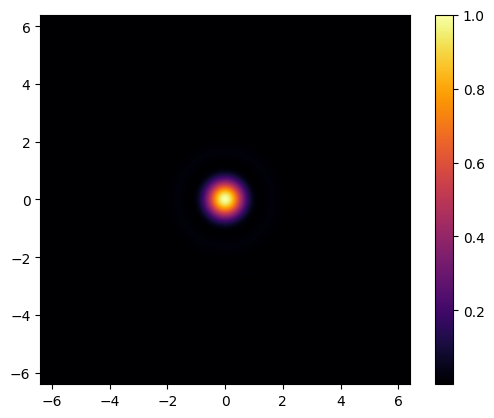

In [ ]:
delta=focal_grid.delta[0]
extent=[(-1024*delta*D/(wavelength)), (1024*delta*D/(wavelength)), (-1024*delta*D/(wavelength)), (1024*delta*D/(wavelength))]
img_ref = prop(EP_xwf).intensity+prop(EP_ywf).intensity
img_ref_norm = (img_ref.shaped / img_ref.max())
# plt.imshow(img_ref_norm, cmap='inferno', extent=extent)
# plt.colorbar()
# plt.show()

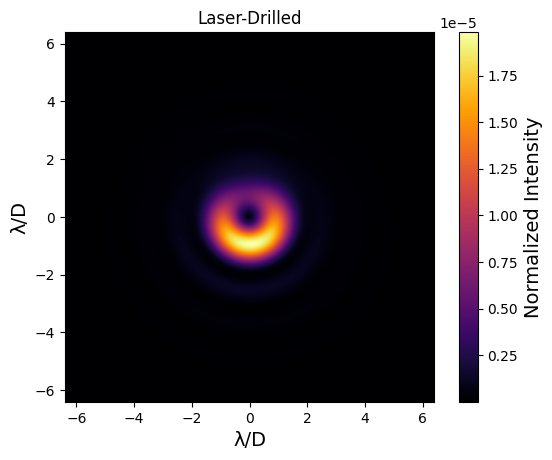

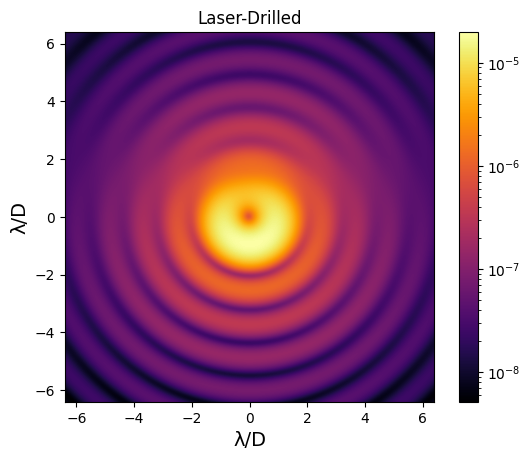

Field(1.9827752e-05)

In [71]:
xpost_lyot_mask = lyot_stop(xlyot_plane)
ypost_lyot_mask = lyot_stop(ylyot_plane)

if perfect:
    img = prop(xlyot_plane).intensity+prop(ylyot_plane).intensity
else:
    img = prop(xpost_lyot_mask).intensity+prop(ypost_lyot_mask).intensity
img_norm = (img.shaped / img_ref.max())

# if perfect_wf:
#     title='Numerical Floor'
# else:
#     title=str(hdr[16])+' μm Diameter'#, Flatness = '+str(hdr[17])+', '+str(hdr[18])+'°'

title='Laser-Drilled'
# title='Microfabricated'

plt.imshow(img_norm, cmap='inferno', extent=extent)
cb=plt.colorbar()
cb.set_label(label='Normalized Intensity', fontsize=14)
plt.title(title)
plt.xlabel('λ/D', fontsize=14)
plt.ylabel('λ/D', fontsize=14)
plt.show()

plt.imshow(img_norm, cmap='inferno', extent=extent, norm=LogNorm())
plt.colorbar()
plt.title(title)
plt.xlabel('λ/D', fontsize=14)
plt.ylabel('λ/D', fontsize=14)
plt.show()
img_norm.max()

Text(0, 0.5, 'Average Radial Contrast')

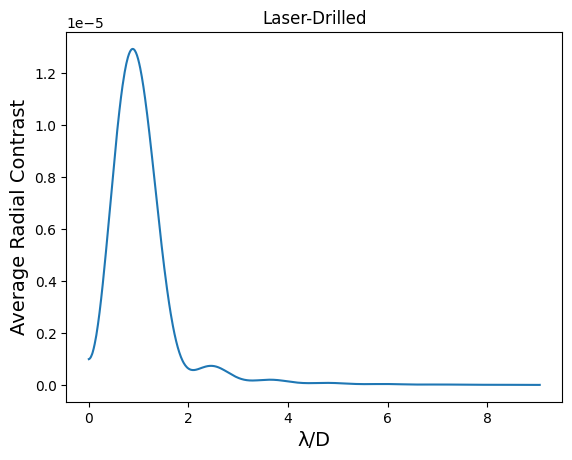

In [72]:
bin_centers, profile, std_profile, num_per_bin = hp.metrics.radial_profile(img/img_ref.max(), 0.000001, statistic='mean')
plt.figure()
plt.plot(bin_centers*D/wavelength, profile)
# plt.title(str(hdr[16])+' μm Diameter Microfabricated')
# plt.title(str(hdr[16])+' μm Diameter Metal')
plt.title(title)
plt.xlabel('λ/D', fontsize=14)
plt.ylabel('Average Radial Contrast', fontsize=14)